# Import Modules

In [1]:
import os
import sys
import pickle

import time
t0 = time.time()

import numpy as np
import pandas as pd

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.local_env import (
    NearNeighbors,
    VoronoiNN, site_is_of_motif_type)

from pymatgen.analysis import local_env

# #############################################################################
from ase_modules.ase_methods import view_in_vesta


sys.path.insert(0, os.path.join(os.environ["PROJ_irox"], "data"))
from proj_data_irox import (
    unique_ids_path,
    )

# Systems with O-O bonds

In [2]:
systems_with_O_O_bonds = {
 '62xp6e9yzs',
 '63xlmhno8h',
 '64vo6w8wvq',
 '656qniby7j',
 '6fzy7kcrxy',
 '6h9ozjn37g',
 '6tvo819y9e',
 '71ndci8rx3',
 '7h62vo74x4',
 '847uxp8gmp',
 '8avd8d7rbe',
 '8dce6kz2vf',
 '8ebo7t6fmh',
 '8jcf9uvdna',
 '8jvfcyvk92',
 '8k72z48d9l',
 '92zoc5vkm5',
 '9emsc3bl7g',
 '9fnimdm395',
 '9p8d7fvjbr',
 'b4nrnqvl8h',
 'b5757fmaxd',
 'b5n5949r6e',
 'bfn273nkc2',
 'bpctcem482',
 'c19an46fbo',
 'c28gcrm4mi',
 'ci6uv5n3zj',
 'cjv5cyz2mi',
 'cqbrnhbacg',
 'cqv5n56q6s',
 'm4vd7ac3by',
 'mony9ibt9r',
 'mpb2movibu',
 'mq8o71z58t',
 'mrn1ch8r6s',
 'muvhc5xj6l',
 'n3bobiv39q',
 'nt8e6qmac2',
 'v2blxebixh',
 'v3ck75caxk',
 'vtntbhvtz3',
 'x19jvf73mh',
 'xdz3v5vgcg',
 'xjng8s8lxi',
 'xk8e8g6acu',
 'xk8ubhclcl',
 'xsnsnozgxq',
 'z26gbl9pme',
 'z36lb3bdcq',
 'ze6y7p9y8i',
 'zebabecec1',
 'zemeclx1vu',
 'zimuby8uzj',
 'zobr6ebk8u',
 'zpne9km3c5',
 'zu6lnfze71',
 'zwnung6s71'}

# Script Inputs

In [3]:
tmp = 42

In [4]:
directory = "out_data"
if not os.path.exists(directory):
    os.makedirs(directory)

# Read Data

In [5]:
from get_data import df_bulk_dft

import copy
df_bulk_dft_full = copy.deepcopy(df_bulk_dft)


# # TEMP | Reduce size of data
# df_bulk_dft = df_bulk_dft.sample(n=0)
# "639a63mabs"
# "npvumg7g93"
# tmp = df_bulk_dft_full.loc[["639a63mabs"]]
# df_bulk_dft = pd.concat([
#     tmp,
#     df_bulk_dft])

df_ids = pd.read_csv(unique_ids_path)

df_bulk_dft.shape: (826, 10)


# Methods

# Create coordination environment DF for each system

In [6]:
print(1.41 + 0.66)
2.3 - (1.41 + 0.66)

2.07


0.22999999999999998

In [7]:
# #############################################################################
def get_structure_coord_df(atoms):
    atoms_i = atoms
    structure = AseAtomsAdaptor.get_structure(atoms_i)

    # CrysNN = local_env.VoronoiNN(
    #     tol=0,
    #     targets=None,
    #     cutoff=13.0,
    #     allow_pathological=False,
    #     weight='solid_angle',
    #     extra_nn_info=True,
    #     compute_adj_neighbors=True,
    #     )

    CrysNN = local_env.CrystalNN(
        weighted_cn=False,
        cation_anion=False,
        distance_cutoffs=(0.01, 0.4),
        x_diff_weight=3.0,
        porous_adjustment=True,
        search_cutoff=7,
        fingerprint_length=None)


    coord_data_dict = dict()
    data_master = []
    for i_cnt, site_i in enumerate(structure.sites):
        site_elem_i = site_i.species_string

        data_dict_i = dict()
        data_dict_i["element"] = site_elem_i
        data_dict_i["structure_index"] = i_cnt

        nn_info_i = CrysNN.get_nn_info(structure, i_cnt)
        data_dict_i["nn_info"] = nn_info_i

        neighbor_list = []
        for neighbor_j in nn_info_i:
            neigh_elem_j = neighbor_j["site"].species_string
            neighbor_list.append(neigh_elem_j)

        neighbor_count_dict = dict()
        for i in neighbor_list:
            neighbor_count_dict[i] = neighbor_count_dict.get(i, 0) + 1

        data_dict_i["neighbor_count"] = neighbor_count_dict
        data_master.append(data_dict_i)

    df_struct_coord_i = pd.DataFrame(data_master)

    return(df_struct_coord_i)

In [8]:
# %%capture

# def method(row_i):
#     atoms_i = row_i["atoms"]
#     df_struct_coord_i = get_structure_coord_df(atoms_i)
#     return(df_struct_coord_i)

# coord_data_dict = df_bulk_dft.apply(method, axis=1).to_dict()

# with open(os.path.join(directory, "coord_data_dict.pickle"), "wb") as fle:
#     pickle.dump(coord_data_dict, fle)

In [9]:
path_i = os.path.join(
    "out_data",
    "coord_data_dict.pickle")
with open(path_i, "rb") as fle:
    coord_data_dict = pickle.load(fle)

# Analyse average O and Ir coordination 

In [10]:
def method(row_i):
    new_column_values_dict = {
        "O_coord": None,
        "Ir_coord": None,
        "O-O_bond": None,
        }

    atoms_i = row_i["atoms"]

    # df_struct_coord_i = get_structure_coord_df(atoms_i)
    df_struct_coord_i = coord_data_dict.get(row_i.name, None)

    if df_struct_coord_i is None:
        return(row_i)
        
    # #########################################################################
    # O coordination to Ir ####################################################
    df_i = df_struct_coord_i[df_struct_coord_i["element"] == "O"]
    coord_list = []
    for i in df_i["neighbor_count"].tolist():
        coord_i = i.get("Ir", None)
        if coord_i is not None:
            coord_list.append(coord_i)
    ave_coord = np.mean(coord_list)
    new_column_values_dict["O_coord"] = ave_coord

    # #########################################################################
    # Ir coordination to O ####################################################
    df_i = df_struct_coord_i[df_struct_coord_i["element"] == "Ir"]
    coord_list = []
    for i in df_i["neighbor_count"].tolist():
        coord_i = i.get("O", None)
        if coord_i is not None:
            coord_list.append(coord_i)
    ave_coord = np.mean(coord_list)
    new_column_values_dict["Ir_coord"] = ave_coord

    # #########################################################################
    # O-O bond detection ######################################################
    O_O_bond_present = False
    df_tmp = df_struct_coord_i[df_struct_coord_i["element"] == "O"]
    for i in df_tmp["neighbor_count"].tolist():
        if "O" in i.keys():
            O_O_bond_present = True
    new_column_values_dict["O-O_bond"] = O_O_bond_present

    # #########################################################################
    for key, value in new_column_values_dict.items():
        row_i[key] = value
    return(row_i)


df_coord = df_bulk_dft.apply(method, axis=1)
df_coord = df_coord.drop(labels=df_bulk_dft.columns, axis=1)

/home/raul_desktop/anaconda2/envs/research-new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/raul_desktop/anaconda2/envs/research-new/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Notebook runtime

In [11]:
run_time = time.time() - t0
print("Notebook run time", run_time, "(s)")

run_per_row = run_time / df_bulk_dft.shape[0]
print("Run time per loop", run_per_row, "(s)")

os.getcwd()

Notebook run time 5.472671270370483 (s)
Run time per loop 0.007517405591168247 (s)


'/mnt/f/Dropbox/01_norskov/00_git_repos/PROJ_IrOx_Active_Learning_OER/workflow/ml_modelling/manually_classify_dft_structures'

# Save Data

In [12]:
# # Pickling data ######################################################
# with open(os.path.join(directory, "df_coord_analysis.pickle"), "wb") as fle:
#     pickle.dump(df_coord, fle)
# # #####################################################################

# TEMP TEMP TEMP

In [13]:
# # coord_data_dict["npvumg7g93"].iloc[0]["nn_info"]
# # dir(coord_data_dict["npvumg7g93"].loc[53]["nn_info"][0]["site"])

# sys_id = "npvumg7g93"

# # #############################################################################
# row_i = df_bulk_dft.loc[sys_id]
# atoms_i = row_i["atoms"]
# structure_i = AseAtomsAdaptor.get_structure(atoms_i)

# # #############################################################################
# df_coord_i = coord_data_dict[sys_id]

# ind = 53


# df_coord_i.loc[ind]["nn_info"][0]["site"].distance(structure_i[ind])

In [15]:
all_oo_bond_distances = []
data_list = []
for sys_id in df_bulk_dft.index:
# for sys_id in ["mpbd6sz1z5"]:
    # #############################################################################
    row_i = df_bulk_dft.loc[sys_id]
    atoms_i = row_i["atoms"]
    structure_i = AseAtomsAdaptor.get_structure(atoms_i)

    # #############################################################################
    df_coord_i = coord_data_dict.get(sys_id, None)

    if df_coord_i is None:
        continue

    oo_bond_distances = []
    for j_cnt, row_j in df_coord_i[df_coord_i["element"] == "Ir"].iterrows():
        for nn_k in row_j["nn_info"]:
            if nn_k["site"].species_string == "O":
                data_dict = dict()


                oo_bond_dist_k = \
                    nn_k["site"].distance(structure_i[row_j["structure_index"]])

                oo_bond_distances.append(oo_bond_dist_k)
                all_oo_bond_distances.append(oo_bond_dist_k)

#                 data_dict["structure_"]
                data_dict["id_unique"] = sys_id
                data_dict["oo_bond_length"] = oo_bond_dist_k
                data_dict["structure_index"] = row_j["structure_index"]

                data_dict = {**data_dict, **row_i}
                data_dict = {**data_dict, **nn_k}

                data_list.append(data_dict)

len(all_oo_bond_distances)

17804

In [16]:
df_oo = pd.DataFrame(data_list)
df_oo = df_oo.sort_values("oo_bond_length", ascending=False)

# df_tmp.sort_values("structure_index", ascending=False)

df_weird = df_oo[df_oo["oo_bond_length"] > 2.3]

weird_ids = df_weird["id_unique"].unique().tolist()

In [17]:
from ase_modules.ase_methods import view_in_vesta
from ase import Atom
# mpbd6sz1z5
# view_in_vesta([atoms_i])

In [18]:
atoms_list = []
names_list = []

grouped = df_oo[df_oo["oo_bond_length"] > 2.3].groupby(["id_unique"])


df_oo_filtered = df_oo[
#     (df_oo["oo_bond_length"] < 2.3) & \
#     (df_oo["oo_bond_length"] > 2.2)
    (df_oo["oo_bond_length"] < 2.3) & \
    (df_oo["oo_bond_length"] > 2.2)
    ]
grouped = df_oo_filtered.groupby(["id_unique"])

for name, group in grouped:

    central_atom_indices = list(set(group["structure_index"].tolist()))

    # #########################################################################
    consistent_oo_bl = False
    bonded_atoms_indices_list = []
    for ind_j, site_j in group.iterrows():
        df_oo_j = df_oo[
            (df_oo["id_unique"] == name) & \
            (df_oo["site_index"] == site_j["site_index"])]
        bonded_atoms_indices = df_oo_j["site_index"].tolist()

        oo_std_dev = df_oo_j["oo_bond_length"].std()
        if oo_std_dev < 0.001:
            consistent_oo_bl = True
#             print(oo_std_dev)

        bonded_atoms_indices = list(set(bonded_atoms_indices))
        bonded_atoms_indices_list +=  bonded_atoms_indices
    bonded_atoms_indices_list = list(set(bonded_atoms_indices_list))
    # #########################################################################

    select_atoms_indices = list(set(group["site_index"].tolist()))

    all_relevant_indices = central_atom_indices + \
        select_atoms_indices + \
        bonded_atoms_indices_list


    # atoms_reduced = df_bulk_dft.loc[name]["atoms"][all_relevant_indices]
    atoms_reduced = df_bulk_dft.loc[name]["atoms"]

#     Replacing O's that have large Ir-O BLs with another atom for visibility
    # new_atoms = []
    # for ind_i  in select_atoms_indices:
    #     # ind_i = select_atoms_indices[0]
    #     # atoms_reduced.append()
    #     atom_i = Atom(symbol="H", position=atoms_reduced[ind_i].position)
    #     new_atoms.append(atom_i)

    # del atoms_reduced[select_atoms_indices]
    # for new_atom in new_atoms:
    #     atoms_reduced.append(new_atom)

    atoms_list.append(atoms_reduced)
    names_list.append(name)

In [19]:
group_dict = {}
for name, group in grouped:
    group_dict[name] = group

In [20]:
group_dict.keys()

dict_keys(['64vo6w8wvq', '6dxsvlbymt', '6tvo819y9e', '71ndxsch8y', '8495vjvsc3', '8561zfxl7q', '8ebo7t6fmh', '8qzamrb4m2', '8uxs7rmu7j', '94x5nkmjmf', '9hc58scr8f', '9lvpvfvaxt', '9sx5z4m1x1', 'be7wm39lmp', 'bjngmqvp9t', 'bt8r6jz26o', 'c19an46fbo', 'c5b59y8d85', 'cfmuzlbrmt', 'cqv5n56q6s', 'mg7ev1mu7i', 'mi8ob2xq9h', 'mjvo7lcwzf', 'mp7svl6j8s', 'mrn1ch8r6s', 'mububjnwc2', 'mwxw7o7f8p', 'n5858d8o9j', 'n5vh62x3vi', 'nhb1vs72b5', 'ni9lbdvi7a', 'nivdbkxfbl', 'npb383nemf', 'v1vpxgbg9s', 'vhck6u84bj', 'vi83m1vkxe', 'vl6uvqne6d', 'vrzwmd6amk', 'x48d9oc591', 'x57yxezkxl', 'xdz3v5vgcg', 'zebabecec1', 'zt6h7jv5m3', 'zuzwxhvuxe', 'zwnung6s71', 'zwzkbkcf8a'])

In [34]:
# group_dict["6dxsvlbymt"]

In [22]:
# from ase import Atom
# for ind_i  in select_atoms_indices:
#     # ind_i = select_atoms_indices[0]

#     atoms_reduced.append(
#         Atom(symbol="He", position=atoms_reduced[ind_i].position)
#         )

In [33]:
print(len(atoms_list))
# view_in_vesta(atoms_list, name_list=names_list)

46


In [24]:
# df_weird

# atoms_list = []
# names_list = []
# grouped = df_weird.groupby(["id_unique"])
# for name, group in grouped:
#     central_atom_indices = list(set(group["structure_index"].tolist()))
#     # group.iloc[0]["site_index"]

#     all_relevant_indices = central_atom_indices + list(set(group["site_index"].tolist()))
#     atoms_reduced = df_bulk_dft.loc[name]["atoms"][all_relevant_indices]
#     atoms_list.append(atoms_reduced)
#     names_list.append(namej)

# # atoms_list

# Plotting Oxy bond length ditribution

In [25]:
from plotting.my_plotly import my_plotly_plot

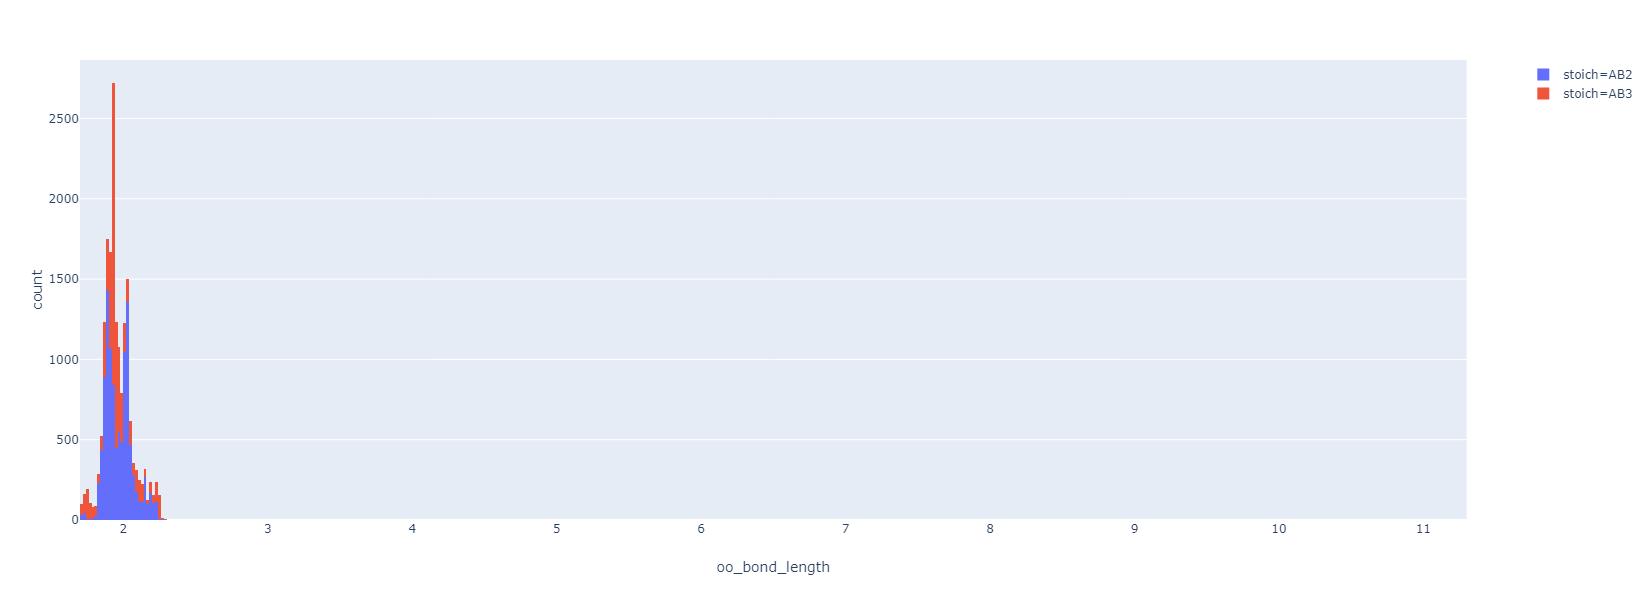

In [38]:
import plotly.express as px

tips = px.data.tips()
fig = px.histogram(df_oo, x="oo_bond_length", nbins=600, color="stoich")
fig.show()

# my_plotly_plot

In [27]:
# df_tmp[df_tmp["structure_index"] == 32]

# df_oo_bonds = pd.DataFrame()
# df_oo_bonds["TEMP"] = all_oo_bond_distances

In [28]:
# pd.DataFrame.sort_values?

In [29]:
# df_oo.sort_values("oo_bond_length")

In [30]:
# df_oo[df_oo["id_unique"] == "6dxsvlbymt"].sort_values(by=["structure_index", "oo_bond_length"])
# df_oo[df_oo["id_unique"] == "639a63mabs"].sort_values

In [31]:
# row_i = df_oo.iloc[0]

# # df_ids.loc[]



# id_row = df_ids[df_ids["unique_ids"] == row_i["id_unique"]]
# stoich_i = id_row["stoich"]

# stoich_i.iloc[0]

# df_oo
# df_ids


# def method(row_i):
#     id_row = df_ids[df_ids["unique_ids"] == row_i["id_unique"]]
#     stoich_i = id_row["stoich"].iloc[0]
#     print(stoich_i)
#     return(stoich_i)

# df_i = df_oo
# # df_i["column_name"] = 
# df_i.apply(
#     method,
#     axis=1,
#     # args=(arg1, ),
#     # optional_arg="TEMP_1"
#     )

In [32]:
# dir(atoms_reduced)

# del atoms[[atom.index for atom in atoms if atom.symbol=='H']]

# atoms_reduced[]

